# Compression algorithms

In this lab we shall explore the four compressino algorithms given to us: Huffmann, LZ77, LZW and DEFLATE compressions

## Work distribution
LZ77 - Petro Mozil
LZW - Dmytro Khamula
HUffmann and DEFLATE codes - Both participants

# Setup

In [26]:
!git clone https://github.com/pmozil/discrete_lab_4
%cd discrete_lab_4
!pip install tqdm

Cloning into 'discrete_lab_4'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 142 (delta 73), reused 100 (delta 38), pack-reused 0
Receiving objects: 100% (142/142), 259.42 KiB | 1.37 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/discrete_lab_4/discrete_lab_4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Basic imports

In [1]:
import matplotlib.pyplot as plt
import time
from collections import Counter
from collections.abc import Sequence
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from typing import Any
import random
import tqdm

# The architecture
Every compressor consists of an encoder and a decoder.
Here are the base class declarations, along with a UML disgra, (sorry for the terrible quality, the site requested payment for png export, so i made a screenshot)
![](https://github.com/pmozil/discrete_lab_4/blob/main/diagrams.png?raw=1)

In [2]:
from abc import ABC, abstractmethod
from collections.abc import Sequence


class BaseEncoder(ABC):
    """
    The encoder abstract base class.
    """

    @abstractmethod
    def encode(self, stream: Sequence) -> Sequence:
        """
        Encode the data and store it in the class

        Args:
            stream: str - the data to encode
        Returns:
            str - the encoded data
        """
        ...


class BaseDecoder(ABC):
    """
    The decoder abstract base class
    """

    @abstractmethod
    def decode(self, stream: Sequence) -> Sequence:
        """
        Decode the data

        Args:
            stream: the encoded data
        Returns:
            str - the decoded data
        """
        ...


class BaseCompressor(ABC):
    """
    The base compressor class
    """

    @property
    @abstractmethod
    def data(self) -> Sequence:
        """
        Get the encoder's stored data (decoded)

        Returns:
            Sequence - The decoded data
        """
        ...

    @data.setter
    @abstractmethod
    def data(self, data: Sequence):
        """
        Setter for the stored data
        """
        ...


# The LZ77 algorithm
This piece of code is optimised for strings. Should you need the general version, get the one from `src/coding/lz77.py`
**The LZ77 algorithm is based on the presumption that the stream of data is repetitive**, as it writes the last couple symbols into a buffer,
and, should the next symbols be repeated, treplaces them with the (distance, length) tuple, which, when decoded will be repaced again with the expected symbols.
With that said, here's the code for the compressor


In [3]:
class LZ77StringEncoder(BaseEncoder):
    """
    The lz77 Encoder
    Methods:
        encode(stream: Sequence) -> Sequence: encodes the stream with lz77
    """

    def __init__(self, buffer_len: int = 128):
        """
        The init for the lz77 encoder
        """
        self._buffer_len = buffer_len
        self._buffer = []

    def _longest_sequence(self, stream: Sequence) -> tuple[int, int]:
        """
        Get longest sequence from the buffer
        """
        cur_len: int = 1
        match: bool = False
        buf_idx = 0
        result_idx = 0
        while (buf_idx + cur_len) < (len(self._buffer)):
            if [ch for ch in stream[:cur_len]] == self._buffer[
                buf_idx : (buf_idx + cur_len)
            ]:
                match = True
                result_idx = buf_idx
                if [ch for ch in stream[: cur_len + 1]] == self._buffer[
                    buf_idx : (buf_idx + cur_len + 1)
                ]:
                    cur_len += 1
                else:
                    buf_idx += 1
            else:
                buf_idx += 1
        return (result_idx, cur_len) if match and cur_len >= 3 else (0, 0)

    def encode(self, stream: Sequence) -> Sequence:
        """
        Encode the given stream
        Args:
            stream: Sequence - the stream of data
        Returns:
            Sequence - the encoded data
        """
        self._buffer = []
        encoded_stream: Sequence[tuple[int, int] | Any] = []
        while stream:
            compression_info: tuple[int, int] = self._longest_sequence(stream)
            if compression_info[1] > 0:
                dist = compression_info[0] - len(self._buffer)
                step = compression_info[1]
                encoded_stream.append((dist, step))
            else:
                step = 1
                symbol = stream[0]
                if (
                    encoded_stream
                    and isinstance(encoded_stream[-1], Sequence)
                    and not isinstance(encoded_stream[-1], tuple)
                ):
                    encoded_stream[-1] += symbol
                else:
                    encoded_stream.append(symbol)
            self._buffer += stream[:step]
            min_index = (
                len(self._buffer) - self._buffer_len - 1
                if len(self._buffer) > self._buffer_len
                else 0
            )
            self._buffer = self._buffer[min_index:]
            stream = stream[step:]
        return encoded_stream


class LZ77StringDecoder(BaseDecoder):
    """
    The LZ77String decoder class
    Methods:
        decode(encoded_stream: Sequence) -> Sequence: decode the lz77 code
    """

    @staticmethod
    def decode(encoded_stream: Sequence[tuple[int, int, str]]) -> Sequence:
        """
        Decode the LZ77String-compressed stream
        """
        decoded_stream = []
        for symbol in encoded_stream:
            if isinstance(symbol, tuple):
                for ch in decoded_stream[symbol[0] :][: symbol[1]]:
                    decoded_stream += [ch]
            else:
                for ch in symbol if isinstance(symbol, Sequence) else [symbol]:
                    decoded_stream += ch

        return decoded_stream


class LZ77StringCompressor(BaseCompressor):
    """
    The lz77 compressor
    Attributes:
        data - the data thet the compress stores.
            It is stored compressed and it is decoded on using the property
    """

    def __init__(self, buffer_len: int = 128):
        """
        Init method for the LZ77StringCompressor
        """
        self._encoder = LZ77StringEncoder(buffer_len)
        self._decoder = LZ77StringDecoder()
        self._data = []

    @property
    def data(self) -> Sequence:
        """
        Getter for the stored data
        Returns:
            Sequence - the decoded data
        """
        return self._decoder.decode(self._data)

    @data.setter
    def data(self, data: Sequence):
        """
        Setter for the stored data
        """
        self._data = self._encoder.encode(data)

Also, the code for the compressor used in DEFLATE:

In [4]:
class LZ77Encoder(BaseEncoder):
    """
    The lz77 Encoder

    Methods:
        encode(stream: Sequence) -> Sequence: encodes the stream with lz77
    """

    def __init__(self, buffer_len: int = 128):
        """
        The init for the lz77 encoder
        """
        self._buffer_len = buffer_len
        self._buffer = []

    def _longest_sequence(self, stream: Sequence) -> tuple[int, int]:
        """
        Get longest sequence from the buffer
        """
        cur_len: int = 1
        match: bool = False
        buf_idx = 0
        result_idx = 0
        while (buf_idx + cur_len) < (len(self._buffer)):
            if [ch for ch in stream[:cur_len]] == self._buffer[
                buf_idx : (buf_idx + cur_len)
            ]:
                match = True
                result_idx = buf_idx
                if [ch for ch in stream[: cur_len + 1]] == self._buffer[
                    buf_idx : (buf_idx + cur_len + 1)
                ]:
                    cur_len += 1
                else:
                    buf_idx += 1
            else:
                buf_idx += 1
        return (result_idx, cur_len) if match and cur_len >= 3 else (0, 0)

    def encode(self, stream: Sequence) -> Sequence:
        """
        Encode the given stream

        Args:
            stream: Sequence - the stream of data

        Returns:
            Sequence - the encoded data
        """
        self._buffer = []
        encoded_stream: Sequence[tuple[int, int] | Any] = []
        while stream:
            compression_info: tuple[int, int] = self._longest_sequence(stream)
            if compression_info[1] > 0:
                dist = compression_info[0] - len(self._buffer)
                step = compression_info[1]
                encoded_stream.append((dist, step))
            else:
                step = 1
                symbol = stream[0]
                encoded_stream.append(symbol)
            self._buffer += stream[:step]
            min_index = (
                len(self._buffer) - self._buffer_len - 1
                if len(self._buffer) > self._buffer_len
                else 0
            )
            self._buffer = self._buffer[min_index:]
            stream = stream[step:]
        return encoded_stream


class LZ77Decoder(BaseDecoder):
    """
    The LZ77 decoder class

    Methods:
        decode(encoded_stream: Sequence) -> Sequence: decode the lz77 code
    """

    @staticmethod
    def decode(encoded_stream: Sequence[tuple[int, int, str]]) -> Sequence:
        """
        Decode the LZ77-compressed stream
        """
        decoded_stream = []
        for symbol in encoded_stream:
            if isinstance(symbol, tuple):
                for ch in decoded_stream[symbol[0] :][: symbol[1]]:
                    decoded_stream += [ch]
            else:
                decoded_stream.append(symbol)

        return decoded_stream


class LZ77Compressor(BaseCompressor):
    """
    The lz77 compressor

    Attributes:
        data - the data thet the compress stores.
            It is stored compressed and it is decoded on using the property
    """

    def __init__(self, buffer_len: int = 128):
        """
        Init method for the LZ77Compressor
        """
        self._encoder = LZ77Encoder(buffer_len)
        self._decoder = LZ77Decoder()
        self._data = []

    @property
    def data(self) -> Sequence:
        """
        Getter for the stored data

        Returns:
            Sequence - the decoded data
        """
        return self._decoder.decode(self._data)

    @data.setter
    def data(self, data: Sequence):
        """
        Setter for the stored data
        """
        self._data = self._encoder.encode(data)


# Huffmann encoding
The huffmann encoding does not need repetitive patterns, but repetitive symbols. It shortens the length of every code, instead of the whole stream. Sorry, no block coding for you >:-[
**Also, threading**

In [5]:
class HuffmannTree:
    """
    The Huffmann Tree node
    """

    def __init__(self, left: "HuffmannTree | str", right: "HuffmannTree | str"):
        self.left = left
        self.right = right


class HuffmannEncoder(BaseEncoder):
    """
    The Huffmann tree class

    Methods:
        encode(stream: Sequence) -> Sequence: encodes the stream with Huffmann Code
    """

    def encode(self, stream: Sequence) -> list[tuple[int, int]]:
        """
        Encode the given stream

        Args:
            stream: Sequence - the stream of data

        Returns:
            Sequence - the encoded data
        """
        nodes: list[tuple[Any, float]] = sorted(
            dict(Counter(stream)).items(), key=lambda x: x[1]
        )
        tree: HuffmannTree = self.make_tree(nodes)
        self.alphabet: dict = self.encoding_from_tree(tree)
        # result = bytearray()
        result = [""]
        for symbol in stream[::-1]:
            # result.append(self.alphabet[symbol])
            code = self.alphabet[symbol]
            # result[-1] = (result[-1] << code.bit_length()) | code
            result[-1] = code + result[-1]
            if len(result[-1]) >= 3600:
                result.append("")
        self.alphabet = {
            val.encode("utf-8"): key for key, val in self.alphabet.items()
        }
        res = []
        for x in result:
            i = 0
            while i < len(x) - 1 and x[i] == "0":
                i += 1
            res.append((i, int(x, base=2)))
        return res[::-1]

    @staticmethod
    def make_tree(nodes: list[tuple[Any, float]]) -> HuffmannTree:
        """
        Make a huffmann tree from
        """
        while len(nodes) > 1:
            (sym_1, freq_1) = nodes[0]
            (sym_2, freq_2) = nodes[1]
            nodes = nodes[2:]
            node = HuffmannTree(sym_1, sym_2)
            nodes.append((node, freq_1 + freq_2))
        return nodes[0][0]

    def encoding_from_tree(
        self, node: "HuffmannTree | str", code: str = "0"
    ) -> dict[Any, str]:
        """
        Create an encoding for the given huffmann tree
        """
        if not isinstance(node, HuffmannTree):
            return {node: code}
        result = {}
        result.update(self.encoding_from_tree(node.left, code + "0"))
        result.update(self.encoding_from_tree(node.right, code + "1"))
        return result


class HuffmannDecoder(BaseDecoder):
    """
    The class for the huffmann decoder

    Methods:
        decode(encoded_stream: Sequence, alphabet: dict[Any, str]) -> Sequence: decode the Huffmann code
    """

    def decode(self, encoded_stream: list[str], alp: dict[bytes, Any]):
        """
        Decode the Huffmann code
        """
        result = []
        alphabet = {val.decode("utf-8"): key for val, key in alp.items()}
        with ThreadPoolExecutor(max_workers=10) as executor:
            substrings = executor.map(
                partial(self.decode_symbol, alphabet), encoded_stream
            )
        for substring in substrings:
            result.extend(substring)
        return result

    @staticmethod
    def decode_symbol(alphabet: dict[str, Any], i: str) -> list[Any]:
        result = []
        while i:
            for code, symbol in alphabet.items():
                if i.startswith(code):
                    i = i[len(code) :]
                    result.append(symbol)
                    break
        return result


class HuffmannCompressor(BaseCompressor):
    """
    The compressor for the huffmann code

    Attributes:
        data: Sequence - the compressed data
    """

    def __init__(self):
        """
        The init method for HuffmannCompressor
        """
        self._encoder = HuffmannEncoder()
        self._decoder = HuffmannDecoder()
        self._data: list[tuple[int, int]] = []

    @property
    def data(self) -> Sequence:
        """
        Getter for the data
        """
        return self._decoder.decode(
            ["0" * x[0] + bin(x[1])[2:] for x in self._data],
            self._encoder.alphabet,
        )

    @data.setter
    def data(self, stream: Sequence):
        """
        Setter for the data
        """
        self._data = self._encoder.encode(stream)

# The deflate algorithm
The deflate algorithm is a bit more complicated than what i've given here, so here is the explanation:
- The code consists of blocks of size up to 65KB, our code does not do that.
- Each block may be encoded 3 ways: no compression (there are cases when this is optimal), lz77 and then predetermined huffmann (lookup tables eat space) and lz77 + custom huffmann. We only implement the last block, as we will compare the size of python objects compressed, thus implementing the other two methods would simply have eatenn more space.

As for the co0de ,here it is:

In [6]:
class DeflateEncoder(BaseEncoder):
    """
    The deflate encoder class

    This is bonkers. Am not putting multiple symbols into one byte, not in python.
    This is a demonstration of what deflate should look like, but with proper tools
    it'd be twice, if not thrice as effective. I, however, am too lazy to implement an
    array that writes data without concern for byte boundaries, on instead of
    +==========+==========+
    | 10101001 | 10100000 |
    +==========+==========+
         |       |    /\
                       |
                    the message stops here, we have 3 symbols in 2 bytes
    We have this
    +==========+==========+==========+
    | 10100000 | 10011000 | 01000000 |
    +==========+==========+==========+
    /\
    |
    bug bad array
    (And it gets waay worse). Maybe, if I DID implement gzip fully, I'd have played around
    with this, but in this specific case, storing messages in bytes is fine.
    """

    def __init__(self, buf_size: int = 128):
        """Init for the encoder"""
        self._huffmann = HuffmannEncoder()
        self._lz77 = LZ77Encoder(buf_size)

    def encode(self, stream: Sequence) -> list:
        """Encode the stream"""
        result = self._huffmann.encode(self._lz77.encode(stream))
        self.alphabet = self._huffmann.alphabet
        return result


class DeflateDecoder(BaseDecoder):
    """
    The decoder for the deflate class
    """

    def __init__(self):
        """Init for the decoder"""
        self._huffmann = HuffmannDecoder()
        self._lz77 = LZ77Decoder()

    def decode(
        self, encoded_stream: list[str], alphabet: dict[bytes, Any]
    ) -> Sequence:
        """Decode the stream"""
        return self._lz77.decode(
            self._huffmann.decode(encoded_stream, alphabet)
        )


class DeflateCompressor:
    """The compressor class"""

    def __init__(self, buf_size: int = 128):
        """Init for the class"""
        self._encoder = DeflateEncoder(buf_size)
        self._decoder = DeflateDecoder()
        self._data: list[str] = []
        self.alphabet: dict[bytes, Any] = {}

    @property
    def data(self) -> Sequence:
        """Get the data"""
        return self._decoder.decode(
            ["0" * x[0] + bin(x[1])[2:] for x in self._data], self.alphabet
        )

    @data.setter
    def data(self, data: Sequence):
        """Encode the data"""
        self._data = self._encoder.encode(data)
        self.alphabet = self._encoder.alphabet

# LZW
Here's the code for the LZW

In [7]:
class LZWEncoder(BaseEncoder):
    '''
    Class of encoding data

    Attributes:
        _data: data to be encoded.
        _dict: dictionary which script uses for encoding.
        You can use default dictionary which represents first 256 ASCII symbols
        or you can specify your own with particular code.

    Methods:
        encode(): main function for encoding data.
        There are two arguments by default which shouldn't be changed.
    '''
    def __init__(self, _dict: dict = {chr(k): k for k in range(256)}) -> None:
        '''
        (self, str, dict) -> None

        Initialization function for class LZWEncoder
        '''
        self._dict = _dict
        self._num = len(_dict)

    def encode(self, data, elem: str = '', encoded_data: list = []) -> list[int]:
        '''
        (self, str, List) -> List

        Main function for encoding data.
        Returns:
            A list of integers which represent encoded data.
        '''
        for char in data:
            new_code = elem + char
            if new_code in self._dict:
                elem = new_code
            else:
                encoded_data.append(self._dict[elem])
                self._dict[new_code] = self._num
                self._num += 1
                elem = char

        if elem:
            encoded_data.append(self._dict[elem])

        return encoded_data


class LZWDecoder(BaseDecoder):
    '''
    Class of decoding data

    Attributes:
        _data: data to be decoded.
        _dict: dictionary which script uses for decoding.
        You can use default dictionary which represents first 256 ASCII symbols
        or you can specify your own with particular code.

    Methods:
        decode(): main function for decoding data.
        There are two arguments by default which shouldn't be changed.
    '''
    def __init__(self, _dict: dict = {k: chr(k) for k in range(256)}) -> None:
        '''
        (self, str, dict) -> None

        Initialization function for class LZWDecoder
        '''
        self._dict = _dict
        self._num = len(_dict)


    def decode(self, data, elem: str = '', decoded_data: list = []) -> str:
        '''
        (self, str, List) -> List

        Main function for encoding data.
        Returns:
            A string which represent decoded data.
        '''
        for code in data:
            if code in self._dict:
                entry = self._dict[code]
                decoded_data.append(entry)
                if elem:
                    self._dict[self._num] = elem + entry[0]
                    self._num += 1
                elem = entry
            else:
                entry = elem + elem[0]
                decoded_data.append(entry)
                self._dict[self._num] = entry
                self._num += 1
                elem = entry[-1]

        return ''.join(decoded_data)


class LZWCompressor(BaseCompressor):
    '''
    LZW Compressor
    '''
    def __init__(self) -> None:
        '''
        (self) -> None

        Initialization function for LZWCompressor
        '''
        self._encoder = LZWEncoder()
        self._decoder = LZWDecoder()
        self._data = []

    @property
    def data(self):
        '''
        Getter for the stored data

        Returns:
            Sequence - the decoded data
        '''
        return self._decoder.decode(self._data)

    @data.setter
    def data(self, data):
        '''
        Setter for the stored data
        '''
        self._data = self._encoder.encode(data = data)

# Timing
We shall test the algorithms on a set of rndomly generate strings of lengths 10 - 2 * 10^5, with a step of 10000.

In [8]:
class Timer:
  """
  The timer class
  """
  characters = [chr(x) for x in range(65, 135)] # some visiible characters
  def __init__(self, compressors: list[BaseCompressor], line_length: int, enc_names = ["LZ77", "Huffmann", "DEFLATE", "LZW"]):
    """Init for the timer class"""
    self.regenerate_line(line_length)
    self.compressors = compressors
    self.enc_names = enc_names
  
  def regenerate_line(self, line_length):
    """Regenerate the line"""
    self.line = "".join(random.choice(self.characters) for _ in range(line_length))

  def time_encoding(self):
    """
    Check the encoding times
    """
    self.algo_enc_time = []
    for enc in self.compressors:
      start = time.time()
      enc.data = self.line
      self.algo_enc_time.append(time.time() - start)
    return self.algo_enc_time

  def time_decoding(self):
    """Check the decoding times"""
    self.algo_dec_time = []
    for enc in self.compressors:
      start = time.time()
      _ = enc.data
      self.algo_dec_time.append(time.time() - start)
    return self.algo_dec_time
  def compression_rates(self):
    """Check the compression rates.
      This one is purely rbitrary, as it only checks lengths.
      The huffmann thingamabob compresses python obects tenfols, as it uses a
      variation of a bit array, but when written to file, the compression is only ~20%.
      Of course it'd be twice as optimal if i used not pickle, but the point still stands.
      THIS CHECKS ONLY THE LENGTH DIFFERENCE, IT DOES NOT EVEN ACCOUNT FOR THE ENCODINF DICTIONARIES
    """
    self.compression_rate = []
    for enc in self.compressors:
      self.compression_rate.append(len(enc._data))
    return self.compression_rate
      

On to the timing! Man, do I not want to write this code

In [9]:
timer = Timer([LZ77StringCompressor(), HuffmannCompressor(), DeflateCompressor(), LZWCompressor()], 10)
enc_times = []
dec_times = []
compression_rates = []
line_lengths = [10 + i for i in range(0, 100000, 1000)]

for i in tqdm.tqdm(line_lengths):
  timer.regenerate_line(i)
  enc_times.append(timer.time_encoding())
  dec_times.append(timer.time_decoding())
  compression_rates.append(timer.compression_rates())

100%|██████████| 100/100 [20:19<00:00, 12.19s/it]


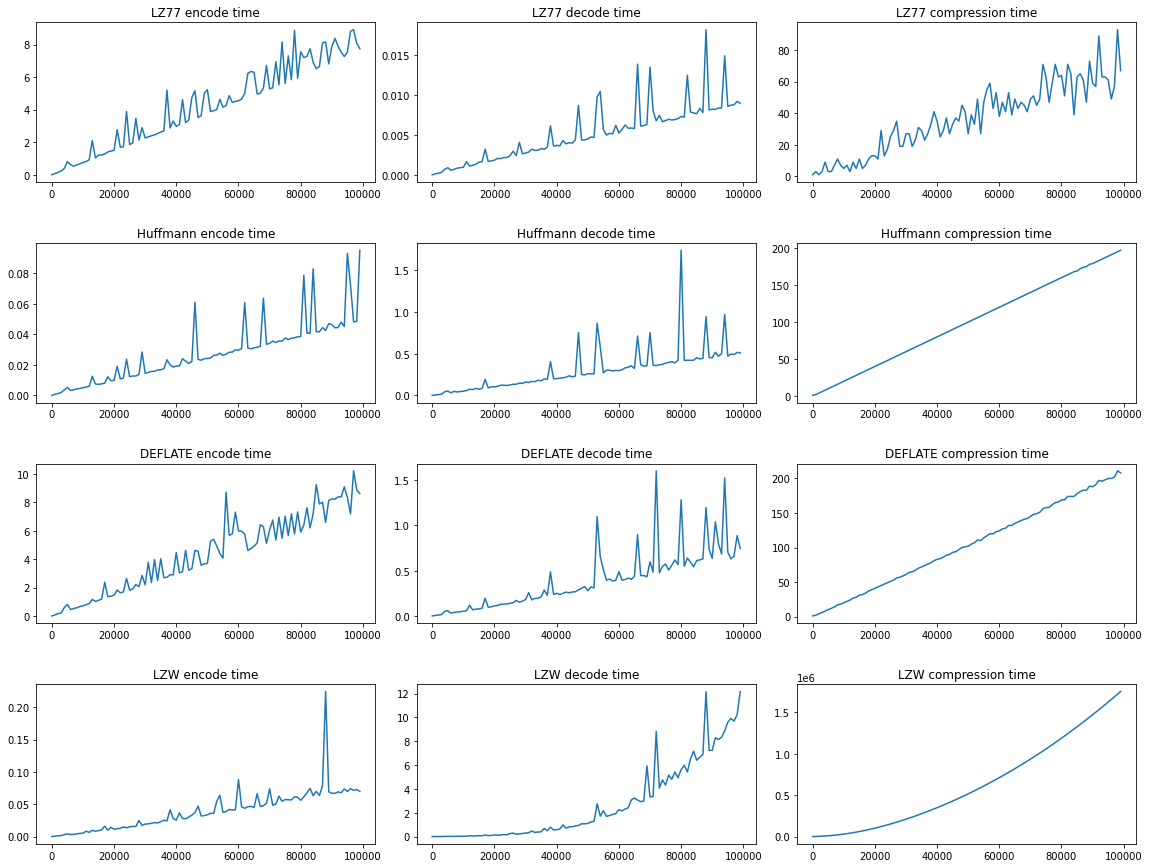

In [10]:
fig, ax = plt.subplots(4, 3, figsize=(16, 12))
fig.tight_layout(h_pad=4)
for i in range(4):
  ax[i, 0].plot(line_lengths, [x[i] for x in enc_times])
  ax[i, 0].set_title(f"{timer.enc_names[i]} encode time")
  ax[i, 1].plot(line_lengths, [x[i] for x in dec_times])
  ax[i, 1].set_title(f"{timer.enc_names[i]} decode time")
  ax[i, 2].plot(line_lengths, [x[i] for x in compression_rates])
  ax[i, 2].set_title(f"{timer.enc_names[i]} compression time")

As expected, LZ77 has terirble encode time.